In [76]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [77]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3

In [78]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [79]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [80]:
len(dataset)

68

In [81]:
32*68

2176

In [82]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 2 0 1 0 0 1 1 1 0 0 1]


In [83]:
print(image_batch[0].shape)

(256, 256, 3)


In [84]:
for image_batch in dataset.take(1):
#     print(image_batch[0])
    print(image_batch[0].numpy())

[[[[154. 147. 155.]
   [154. 147. 155.]
   [152. 145. 153.]
   ...
   [170. 166. 180.]
   [164. 160. 174.]
   [156. 152. 166.]]

  [[160. 153. 161.]
   [161. 154. 162.]
   [159. 152. 160.]
   ...
   [168. 164. 178.]
   [167. 163. 177.]
   [162. 158. 172.]]

  [[161. 154. 162.]
   [165. 158. 166.]
   [165. 158. 166.]
   ...
   [161. 157. 171.]
   [164. 160. 174.]
   [164. 160. 174.]]

  ...

  [[106.  94. 104.]
   [107.  95. 105.]
   [107.  95. 105.]
   ...
   [117. 105. 117.]
   [116. 104. 116.]
   [107.  95. 107.]]

  [[116. 104. 114.]
   [118. 106. 116.]
   [118. 106. 116.]
   ...
   [122. 110. 122.]
   [124. 112. 124.]
   [118. 106. 118.]]

  [[106.  94. 104.]
   [110.  98. 108.]
   [115. 103. 113.]
   ...
   [120. 108. 120.]
   [122. 110. 122.]
   [116. 104. 116.]]]


 [[[151. 145. 147.]
   [160. 154. 156.]
   [161. 155. 157.]
   ...
   [169. 163. 167.]
   [171. 165. 169.]
   [165. 159. 163.]]

  [[169. 163. 165.]
   [163. 157. 159.]
   [158. 152. 154.]
   ...
   [167. 161. 165.]
 

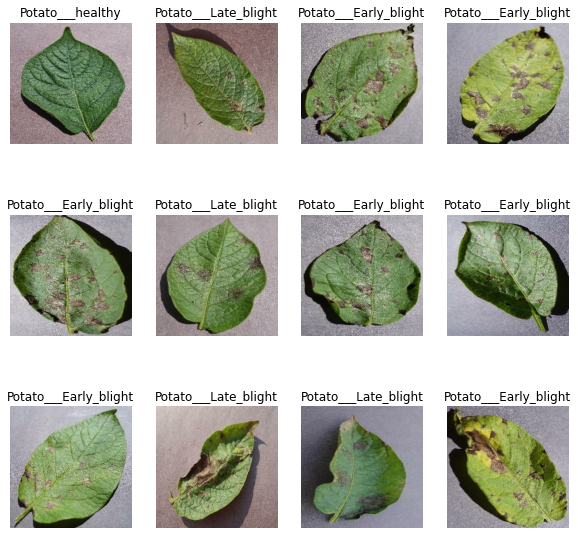

In [85]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))   # Expects 3D array
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [86]:
label_batch.shape

TensorShape([32])

In [87]:
len(dataset)

68

In [88]:
# 80%  -> training data
# 20%  =>
#      -> 10% validation
#      -> 10% testing
        

In [89]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [90]:
train_ds=dataset.take(54)   # taking first 54 batches
len(train_ds)

54

In [91]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [92]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [93]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [94]:
test_ds=test_ds.take(6)
len(test_ds)

6

In [95]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [96]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)
train_ds,val_ds,test_ds

(<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [97]:
len(train_ds)

54

In [98]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [99]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    # images are already 256*256 then why do we resizing it
    # 
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [100]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

---------------------------------------------------------------------

In [102]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    # 32 layers hai trial and error se
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,activation='relu',kernel_size=(3,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,activation='relu',kernel_size=(3,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=input_shape)

In [103]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   multiple                  0         
                                                                 
 sequential_5 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_30 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                 

In [104]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [107]:
history=model.fit(
    train_ds,
    epochs=5,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/5
54/54 [==============================] - 72s 1s/step - loss: 0.9149 - accuracy: 0.4653 - val_loss: 0.8484 - val_accuracy: 0.4740
Epoch 2/5
54/54 [==============================] - 81s 1s/step - loss: 0.8367 - accuracy: 0.5608 - val_loss: 0.6947 - val_accuracy: 0.6875
Epoch 3/5
54/54 [==============================] - 79s 1s/step - loss: 0.6904 - accuracy: 0.7118 - val_loss: 0.5595 - val_accuracy: 0.7448
Epoch 4/5
54/54 [==============================] - 74s 1s/step - loss: 0.5010 - accuracy: 0.7841 - val_loss: 0.4497 - val_accuracy: 0.8177
Epoch 5/5
54/54 [==============================] - 75s 1s/step - loss: 0.4065 - accuracy: 0.8200 - val_loss: 0.4198 - val_accuracy: 0.8125


In [110]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 3s 346ms/step - loss: 0.3827 - accuracy: 0.8359


In [111]:
scores

[0.3827002942562103, 0.8359375]

In [112]:
history

In [113]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [115]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [120]:
EPOCHS=5

In [121]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

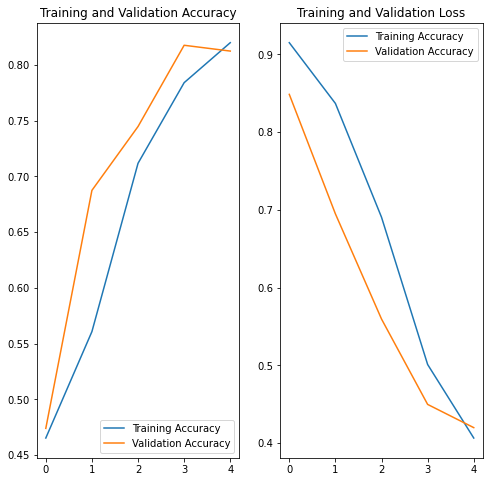

In [124]:
plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Accuracy')
plt.plot(range(EPOCHS),val_loss,label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [146]:
import numpy as np

First Image to Predict
First Image's Actual Label  Potato___Early_blight
1/1 [==============================] - 0s 394ms/step
Predicted Label  Potato___Early_blight


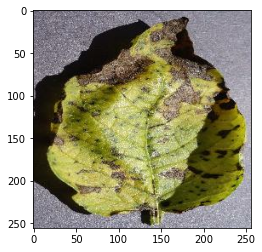

In [149]:
for image_batch,label_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    
    print("First Image to Predict")
    plt.imshow(first_image)
    print("First Image's Actual Label ",class_names[first_label])
    
    batch_prediction=model.predict(image_batch)
    print("Predicted Label ",class_names[np.argmax(batch_prediction[0])])

In [162]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)  
    
    predictions=model.predict(img_array)
    
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100 * (np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 27ms/step


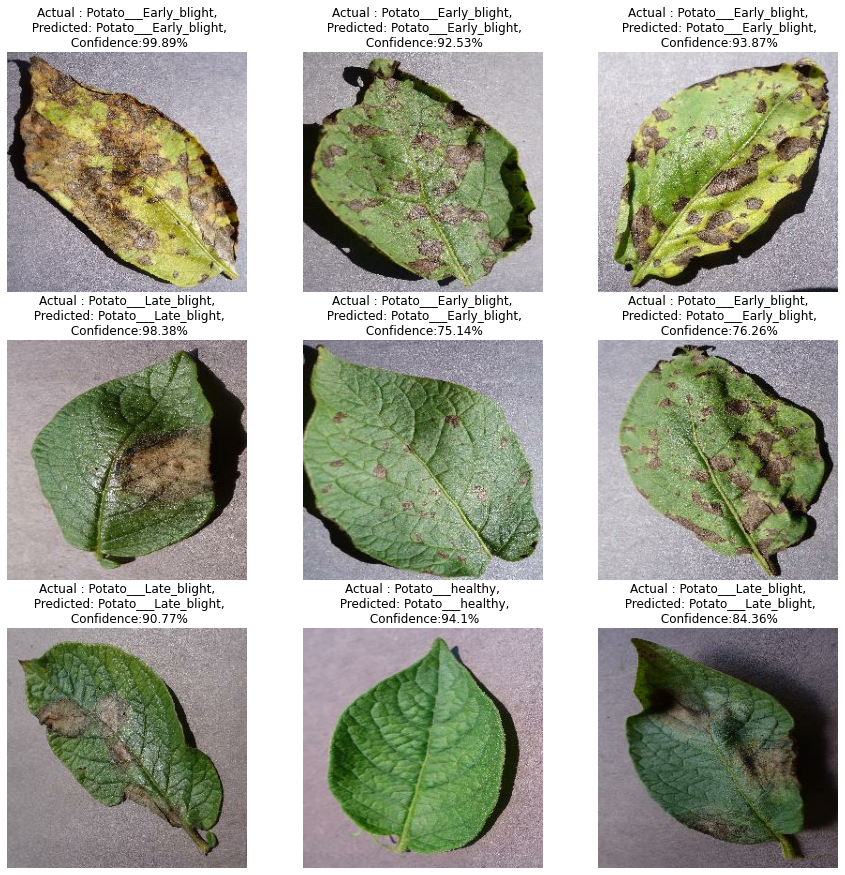

In [164]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual : {actual_class},\n Predicted: {predicted_class},\n Confidence:{confidence}%")
        plt.axis("off")

In [167]:
model_version=1
model.save(f"/Models/{model_version}")

INFO:tensorflow:Assets written to: Models/1\assets


INFO:tensorflow:Assets written to: Models/1\assets
